In [1]:
from Data.cleandata import *

import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE

from sklearn.impute import KNNImputer

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

import warnings
warnings.filterwarnings("ignore")

In [2]:
namefile = "estacion_data_calidadaire_28_20160101_20201231.txt"
df = cleandata(namefile,0,3)

NewTimeSeries = pd.date_range(start='2016-01-01', end='2021-01-01', freq='H')

df_pm25_full = pd.DataFrame({'fecha_hora':NewTimeSeries})
df_pm25_full.index = df_pm25_full['fecha_hora']
del df_pm25_full['fecha_hora']

df_pm25 = df['pm25']

df_pm25_full['pm25']=np.NaN
for i in df_pm25_full.index:
  if(i in df_pm25.index):
    df_pm25_full['pm25'][i]=df_pm25[i]
  else:
    df_pm25_full['pm25'][i]=np.NaN

imputer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean')
imputer.fit(df_pm25_full)
df_pm25_full['new_pm25'] = imputer.transform(df_pm25_full)

dataframe_pm25 = df_pm25_full['2016-09-01':'2020-03-01']

pm25_daily = dataframe_pm25.resample('D').mean()

pm25_daily_copy = pm25_daily.copy()

del pm25_daily['pm25']

pm25_daily

,new_pm25
fecha_hora,
2016-09-01,36.625000
2016-09-02,29.672456
2016-09-03,26.458333
2016-09-04,18.375000
2016-09-05,24.791667
...,...
2020-02-26,31.208333
2020-02-27,43.750000
2020-02-28,44.708333


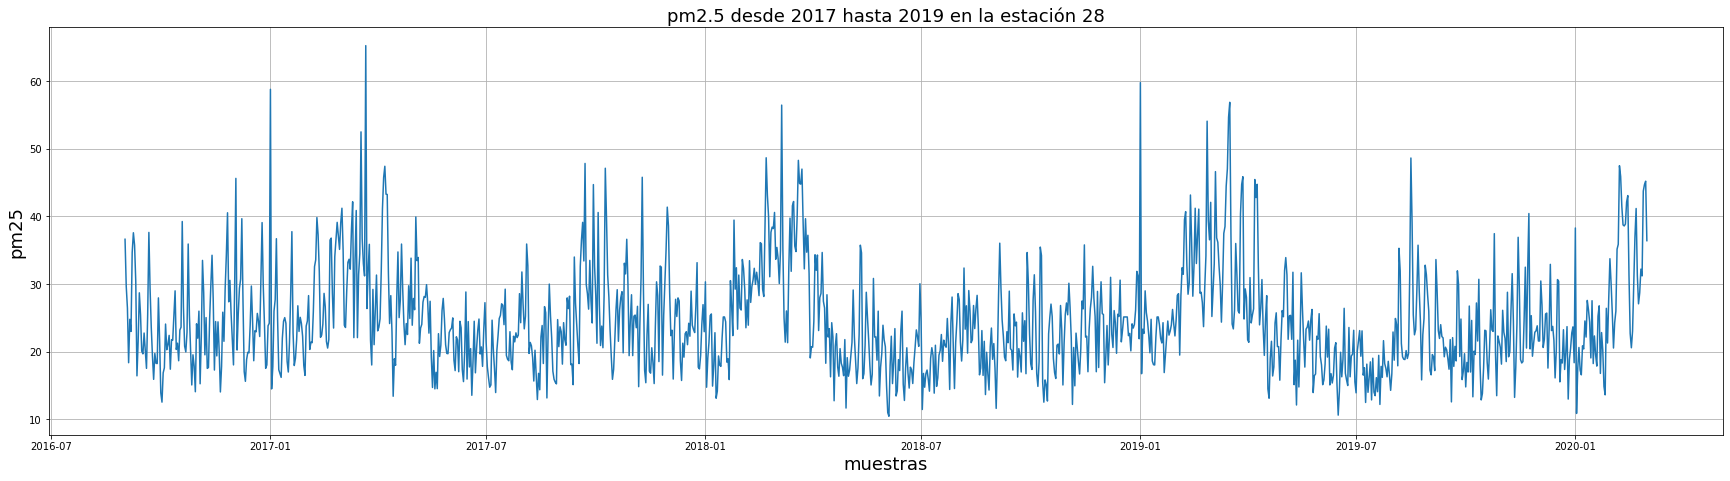

In [3]:
plt.figure(figsize=(30,7.5))
plt.plot(pm25_daily['new_pm25'])
plt.xlabel('muestras',fontsize=18)
plt.ylabel('pm25',fontsize=18)
plt.title('pm2.5 desde 2017 hasta 2019 en la estación 28',fontsize=18)
plt.grid()
plt.show()

## Metricas de desempeño

### ME (Error medio)

Métrica simple pero está sesgada por el efecto de compensación de errores de predicción positivos y negativos, que pueden ocultar la imprecisión de la predicción para observaciones concretas. Debido a eso, el ME no es muy útil para la evaluación de modelos. Es útil para modelos especificos.

In [4]:
def ME(x, y):
    return np.sum(x-y) / len(x)

In [5]:
x = np.array([1, 2, 3, 4])
y = np.array([10, 9, 8, 7])

ME(x, y)

-6.0

### MAE (Error absoluto medio)

Utiliza los valores absolutos de los errores en los cálculos, lo que arregla el problema de la cancelación de errores con signos opuestos. Nos da un promedio de la magnitud absoluta de todos los valores de los errores, sin importar si eran positivos o negativos.

In [6]:
def MAE(x, y):
    return np.sum(np.abs(x-y)) / len(x)

In [7]:
x = np.array([1, 2, 3, 4])
y = np.array([10, 9, 8, 7])

MAE(x, y)

6.0

### MSE (Error cuadrático medio)

Al igual que el MAE, el error cuadrático medio (MSE) también arregla el problema de la cancelación de errores positivos y negativos. Sin embargo, otorga una mayor penalización en los errores de predicción grandes que el MAE.

In [8]:
def MSE(x, y):
    return np.sum((x-y)**2) / len(x)

In [9]:
x = np.array([1, 2, 3, 4])
y = np.array([10, 9, 8, 7])

MSE(x, y)

41.0

### RMSE (Raiz del error cuadrático medio)

En estadística se conoce como desviación estándar de los errores. El RMSE comparte las ventajas del MSE y se utiliza comúnmente en la predicción y análisis de las regresiones para verificar resultados experimentales. Además, tiene la ventaja de tener las mismas unidades que la variable predicha, por lo que es más fácil de interpretar directamente.

In [10]:
def RMSE(x, y):
    return (np.sum((x-y)**2) / len(x))**(0.5)

In [11]:
x = np.array([1, 2, 3, 4])
y = np.array([10, 9, 8, 7])

RMSE(x, y)

6.4031242374328485

### MPE (Error porcentual medio)

Es el promedio de errores porcentuales por los que cada previsión difiere de sus correspondientes valores reales observados. Proporciona el error en términos de porcentajes. Al igual que en el ME, los errores de previsión positivos y negativos pueden compensarse entre sí, por lo que se puede utilizar para medir el sesgo en las previsiones. La desventaja de esta estadística es que no es adecuada para conjuntos de datos que contienen valores observados iguales a cero (pues estos están en el denominador de todos los elementos del sumatorio y un valor nulo implicaría un MPE indefinido arbitrariamente grande).

In [12]:
def MPE(x, y):
    return np.sum((x-y)/x) *100 / len(x)

In [13]:
x = np.array([1, 2, 3, 4])
y = np.array([10, 9, 8, 7])

MPE(x, y)

-372.91666666666663

### MAPE (Error porcentual absoluto medio)

Arregla el problema con la compensación de errores (tal y como lo hacía el MAE). El MAPE es sensible a la escala y se vuelve sin sentido para bajos volúmenes de datos.

In [14]:
def MAPE(x, y):
    return np.sum((np.abs(x-y))/x) *100 / len(x)

In [15]:
x = np.array([1, 2, 3, 4])
y = np.array([10, 9, 8, 7])

MAPE(x, y)

372.91666666666663

# Errores Relativos

### Median Relative Absolute Error (MdRAE)

In [16]:
def MDRAE(x, y, x_train):
    y_bnchmrk = x_train[-365:].values
    return np.median(np.abs(x.values - y.values)/np.abs(x.values - y_bnchmrk))

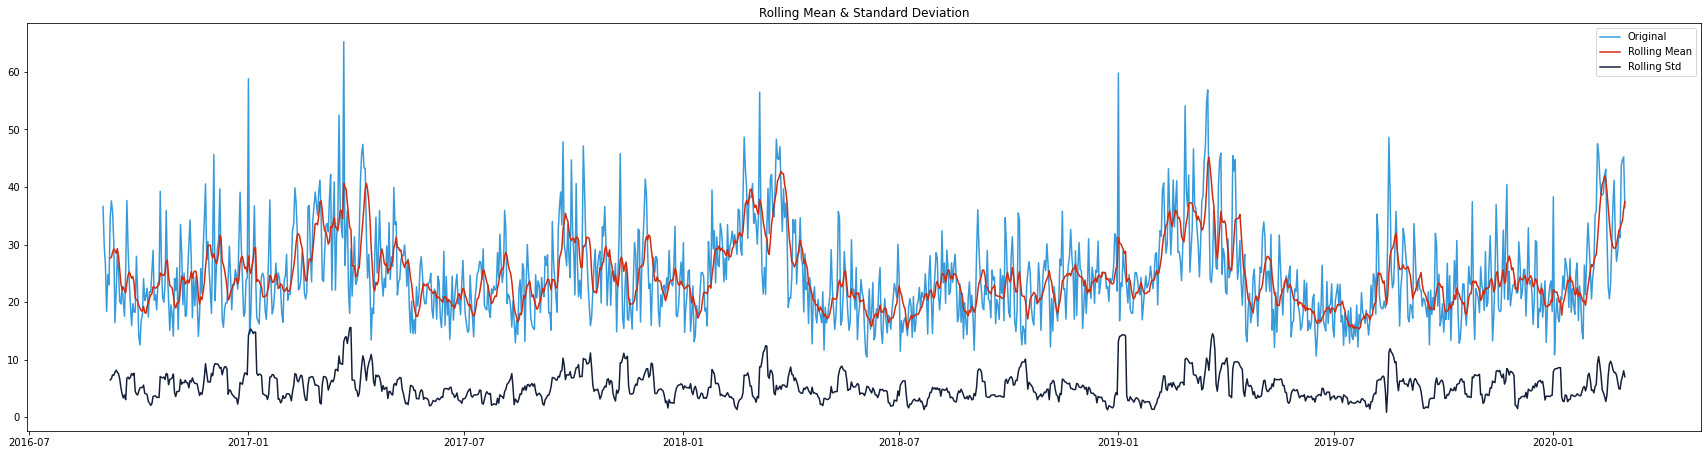

In [17]:
#Determine rolling statistics
pm25_daily["rolling_avg"] = pm25_daily['new_pm25'].rolling(window=7).mean() #Size 7 denotes 7 days
pm25_daily["rolling_std"] = pm25_daily['new_pm25'].rolling(window=7).std()

#Plot rollin statistics
plt.figure(figsize=(30,7.5))
plt.plot(pm25_daily['new_pm25'], color='#379BDB', label='Original')
plt.plot(pm25_daily["rolling_avg"], color='#D22A0D', label='Rolling Mean')
plt.plot(pm25_daily["rolling_std"], color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show()

# Prueba de Dickey-Fuler aumentada

In [18]:
#Augmented Dickey–Fuller test:
print('Results of Dickey Fuller Test:')
dftest = adfuller(pm25_daily['new_pm25'], autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
    
print(dfoutput)

Results of Dickey Fuller Test:
Test Statistic                   -4.149871
p-value                           0.000800
#Lags Used                       13.000000
Number of Observations Used    1264.000000
Critical Value (1%)              -3.435534
Critical Value (5%)              -2.863829
Critical Value (10%)             -2.567989
dtype: float64


Los datos son estacionarios p < 0.05

### Separar test de entrenamiento

In [19]:
# Separación del dataset
X_train, X_test = train_test_split(pm25_daily['new_pm25'], test_size=0.2856, shuffle=False)

# Selección de modelo ARIMA con Auto-ARIMA

In [20]:
#Standard ARIMA Model
ARIMA_model = pm.auto_arima(X_train, 
                      start_p=1, 
                      start_q=1,
                      test='adf', # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1, # frequency of series (if m==1, seasonal is set to FALSE automatically)
                      d=None,# let model determine 'd'
                      seasonal=False, # No Seasonality for standard ARIMA
                      trace=False, #logs 
                      error_action='warn', #shows errors ('ignore' silences these)
                      suppress_warnings=True,
                      stepwise=True)

## Se interpreta el modelo como un buen ajuste en base a las siguientes condiciones

### Residual estandarizado

No hay patrones obvios en los residuos, con valores que tienen una media de cero y una varianza uniforme.

### Histograma más estimación de KDE

La curva KDE debe ser muy similar a la distribución normal (etiquetada como N(0,1) en la gráfica).

### Q Q normal

La mayoría de los puntos de datos deben estar en línea recta.

### Correlograma (gráfico ACF)

El 95% de las correlaciones para un retraso superior a cero no deberían ser significativas. El área gris es la banda de confianza, y si los valores caen fuera de esto, entonces son estadísticamente significativos. En este caso, hay algunos valores fuera de esta área y, por lo tanto, es posible que debamos agregar más predictores para que el modelo sea más preciso.

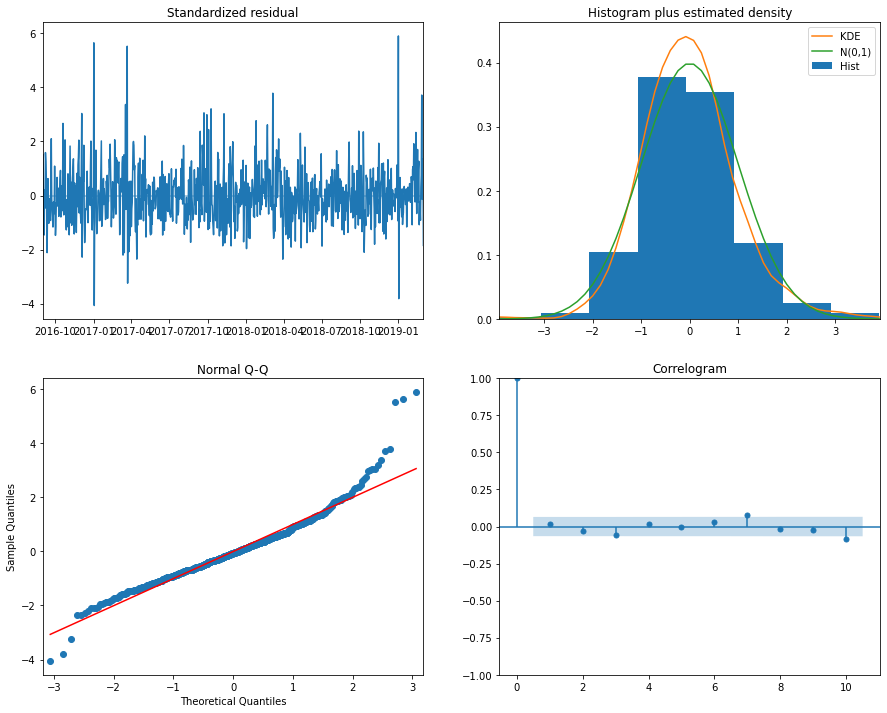

In [21]:
ARIMA_model.plot_diagnostics(figsize=(15,12))
plt.show()

# Predicción con el modelo ARIMA

In [22]:

from cProfile import label


def forecast(ARIMA_model, periods=len(X_test)):
    # Forecast
    n_periods = periods
    fitted, confint = ARIMA_model.predict(n_periods=n_periods, return_conf_int=True)
    index_of_fc = X_test.index

    # make series for plotting purpose
    # fitted_series = pd.Series(fitted, index=index_of_fc)
    fitted.index = index_of_fc
    lower_series = pd.Series(confint[:, 0], index=index_of_fc)
    upper_series = pd.Series(confint[:, 1], index=index_of_fc)

    # Plot
    plt.figure(figsize=(30,7.5))
    # plt.plot(X_train, color='#1f76b4', label='Entrenamiento')
    plt.plot(X_test, color='g', label='Esperado')
    plt.plot(fitted, color='r', label='Predicción')
    
    plt.legend(loc='best')
    plt.title("ARIMA - Forecast pm2.5")
    plt.grid()
    plt.show()

    print('ME: ', ME(X_test, fitted))
    print('MAE: ', MAE(X_test, fitted))
    print('MSE: ', MSE(X_test, fitted))
    print('RMSE: ', RMSE(X_test, fitted))
    print('MPE: ', MPE(X_test, fitted))
    print('MAPE: ', MAPE(X_test, fitted))
    print('MdRAE: ', MDRAE(X_test, fitted, X_train))

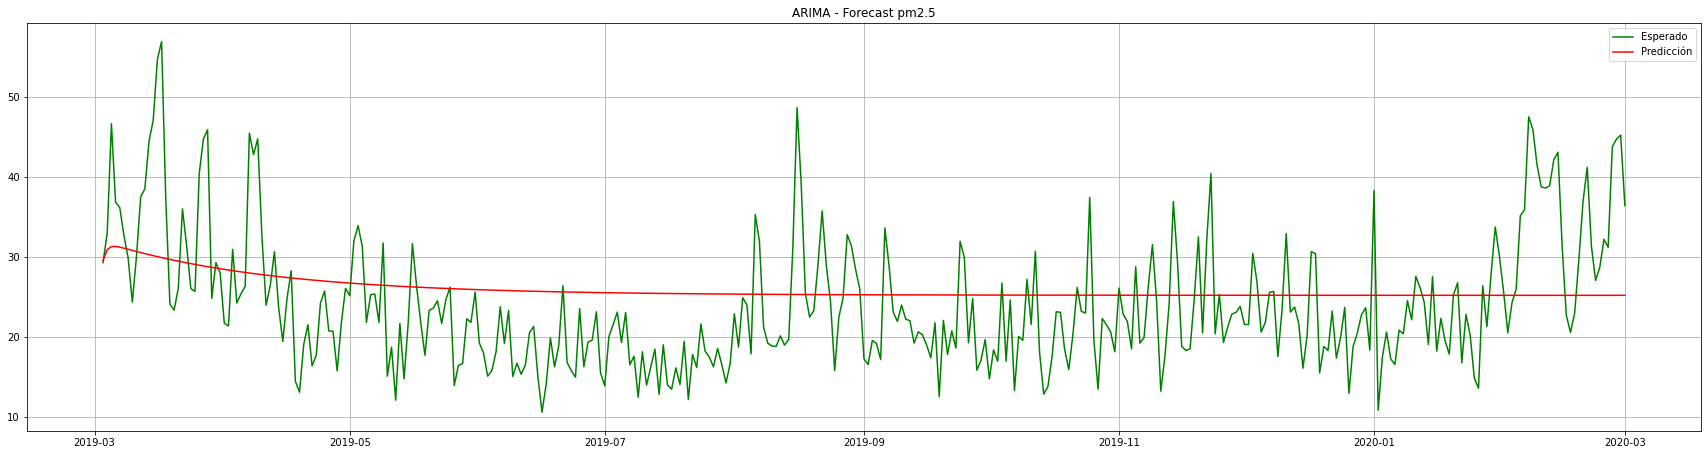

ME:  -1.9207481644431326
MAE:  6.454966645520586
MSE:  62.95847809165818
RMSE:  7.934637867707522
MPE:  -18.509598370799644
MAPE:  30.325582643557933
MdRAE:  1.104490227027978


In [23]:
forecast(ARIMA_model)

# Selección y predicción del modelo SARIMA

In [24]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model_30days = pm.auto_arima(X_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=30, #The frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

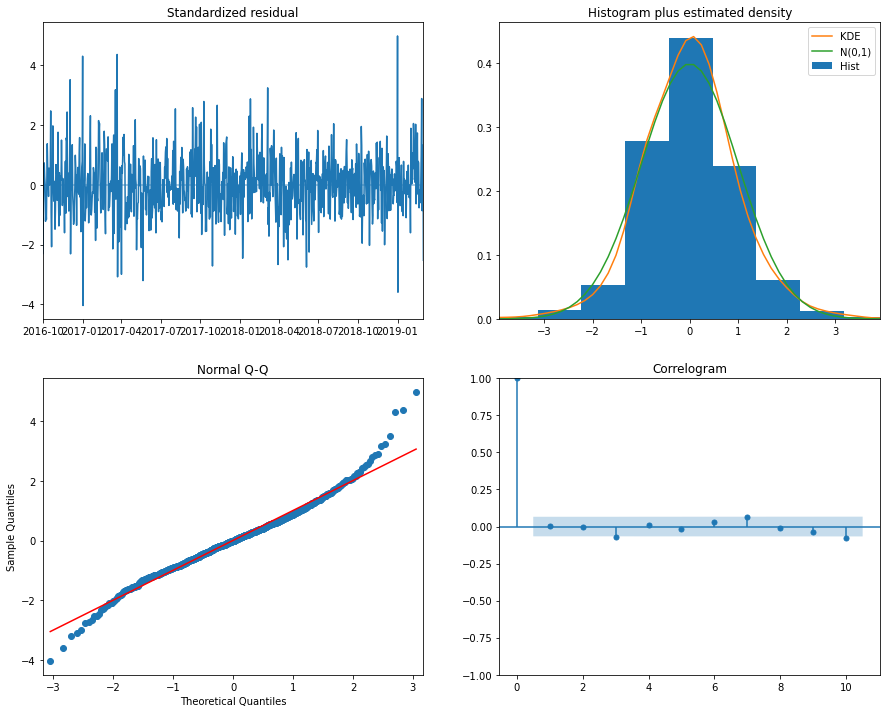

In [25]:
SARIMA_model_30days.plot_diagnostics(figsize=(15,12))
plt.show()

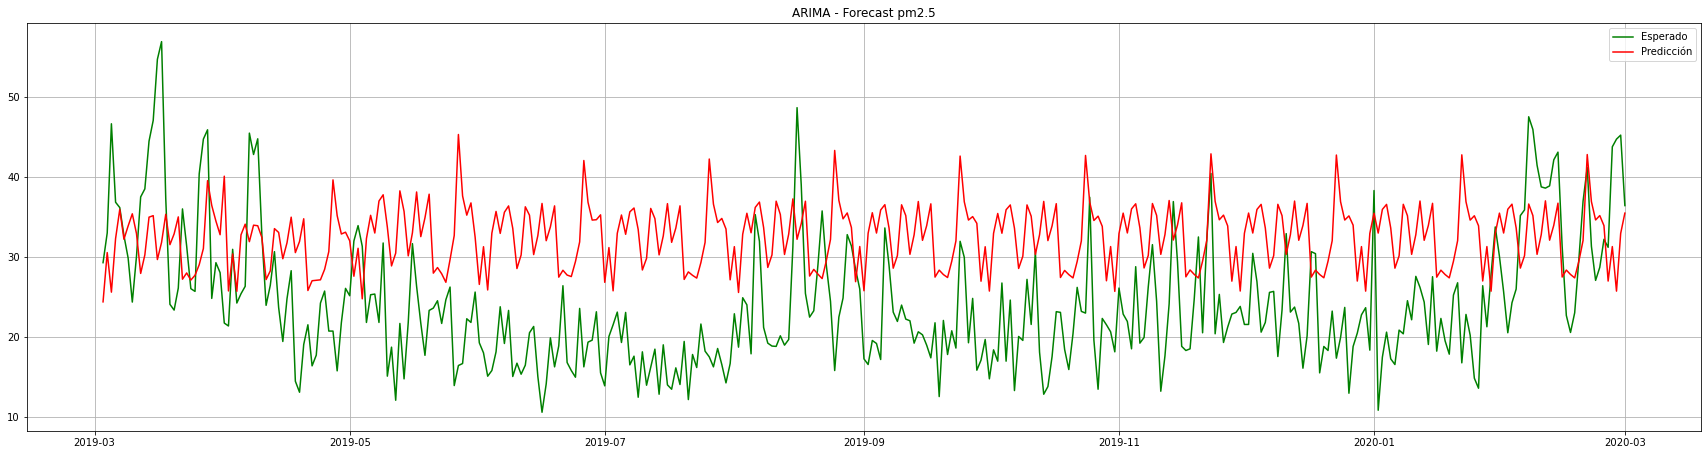

ME:  -8.477596130563706
MAE:  10.694126321091778
MSE:  151.30159860836955
RMSE:  12.30047147910882
MPE:  -49.202051609253516
MAPE:  54.52779807514402
MdRAE:  2.093255188797587


In [26]:
forecast(SARIMA_model_30days)

In [15]:
# Seasonal - fit stepwise auto-ARIMA
SARIMA_model_1year = pm.auto_arima(X_train, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, 
                         m=365, #The frequncy of the cycle
                         start_P=0, 
                         seasonal=True, #set to seasonal
                         d=None, 
                         D=1, #order of the seasonal differencing
                         trace=False,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

MemoryError: Unable to allocate 4.59 GiB for an array with shape (732, 732, 1150) and data type float64

Exception ignored in: 'statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.reset_filter_method'
Traceback (most recent call last):
  File "statsmodels\tsa\statespace\_kalman_smoother.pyx", line 1000, in statsmodels.tsa.statespace._kalman_smoother.dKalmanSmoother.allocate_arrays
numpy.core._exceptions.MemoryError: Unable to allocate 4.59 GiB for an array with shape (732, 732, 1150) and data type float64


AttributeError: Memoryview is not initialized

In [ ]:
SARIMA_model_1year.plot_diagnostics(figsize=(15,12))
plt.show()

In [ ]:
forecast(SARIMA_model_1year)

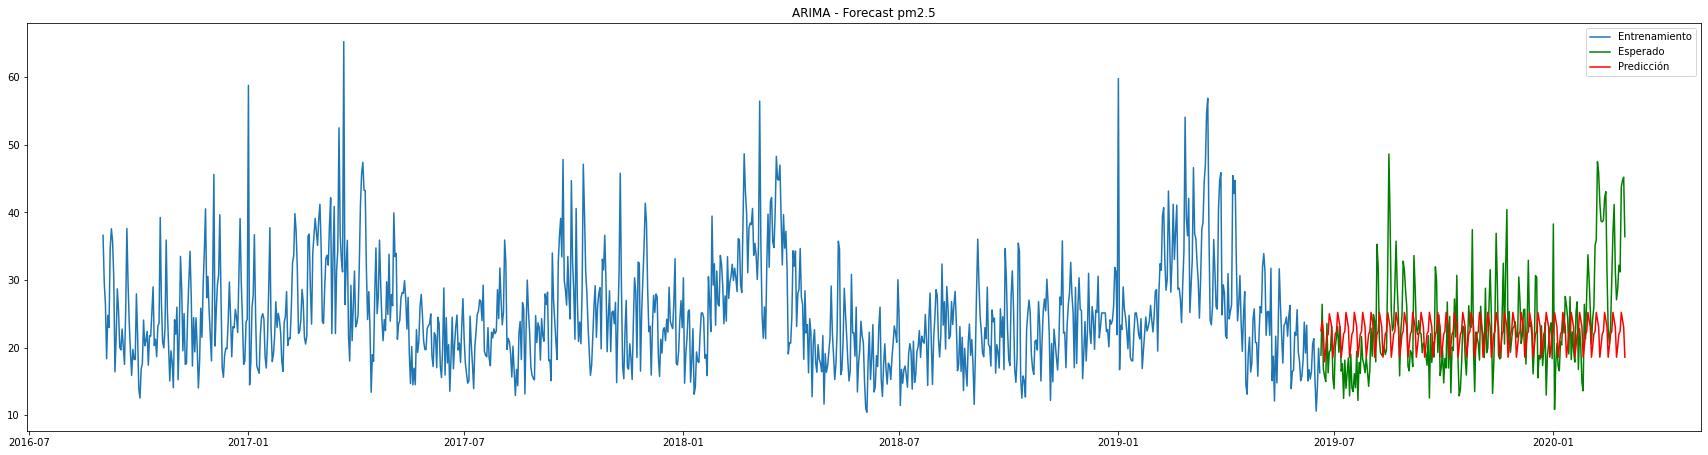

In [12]:
forecast(SARIMA_model_7days)

https://towardsdatascience.com/time-series-forecasting-with-arima-sarima-and-sarimax-ee61099e78f6

https://polmartisanahuja.com/metricas-de-evaluacion-de-rendimiento-para-predicciones-de-series-temporales/